In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [4]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [5]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [6]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [8]:
data_rf = feature_engineer(data)

In [9]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [10]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [11]:
print(train_rf_x.shape) # Performed features normalization
print(train_y.shape)
print(test_rf_x.shape) # Performed features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [12]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
train_score_scaler = StandardScaler()
test_score_scaler = StandardScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [13]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)

# Feature Engineering Part_2: Create N-way interaction features

In [14]:
from sklearn.preprocessing import PolynomialFeatures

In [15]:
# The interaction features can be as 2-way interaction, 3 way or more by adjusting the polynomial degree
n_way_interactions = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [16]:
n_way_interactions_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [17]:
train_interactions = pd.DataFrame(n_way_interactions.fit_transform(train_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(train_rf_x[n_way_interactions_columns].columns))
test_interactions = pd.DataFrame(n_way_interactions.fit_transform(test_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(test_rf_x[n_way_interactions_columns].columns))

In [18]:
train_rf_x_interaction = pd.concat([train_rf_x,train_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
test_rf_x_interaction = pd.concat([test_rf_x,test_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
print(train_rf_x_interaction.shape)
print(test_rf_x_interaction.shape)

(137, 767)
(100000, 767)


# XGboost, Grid Search with Features without interaction & log_transformation_y_

In [15]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle

In [82]:
hyperparameters_dict = {"learning_rate": [0.1,0.2,0.3],              # range: [0,1], default = 0.3
                   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
                   # The larger gamma is, the more conservative the algorithm will be.                   
                   "gamma": [i/10.0 for i in range(1,10,2)],
                   # Maximum depth of a tree. 
                   # Increasing this value will make the model more complex and more likely to overfit
                   "max_depth": [6], 
                   # Used to control over-fitting
                   # Too high values can lead to under-fitting hence, it should be tuned using grid search
                   "min_child_weight": [1],
                   # Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced
                   "max_delta_step": [0],
                   # Denotes the fraction of observations to be randomly samples for each tree
                   # Typical values: 0.5-1
                   "subsample": [0.8],
                   # Similar to max_features in GBM, Typical values: 0.5 - 1
                   # Denotes the fraction of columns to be randomly samples for each tree.
                   "colsample_bytree": [0.8,1],
                   "colsample_bylevel": [1], # colsample_bytree will control the decision over this, default = 1
                   "colsample_bynode": [1],  # colsample_bytree will control the decision over this, default = 1
                   # L2 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_lambda": [1], # default = 1
                   # L1 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_alpha": [1],  # default = 0
                   # Control the balance of positive and negative weights, useful for unbalanced classes. 
                   # A typical value to consider: sum(negative instances) / sum(positive instances)
                   "scale_pos_weight": [1],
                   # No. of trees ensemble, too high sometimes still can cause overfitting
                   "n_estimators": [300,400], 
                   "booster": ["gbtree"],
                   "verbosity": [1],
                   "objective": ["reg:squarederror"],
                   "seed": [50]
                   }

In [103]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0.7],                       # 3rd
                          'max_depth': [8],                     # 1st to tune
                          'min_child_weight': [1],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.8],                   # 4th
                          'colsample_bytree': [0.8],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [300],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [50]
                         }                

In [88]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [89]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 6, iid = False, scoring="neg_mean_squared_error")

In [90]:
xgboost_grid.fit(Train_X,Train_Y)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0.7], 'max_depth': [8], 'min_child_weight': [1], 'max_delta_step': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [1], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [300], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'seed': [50]},
       pre_dispatch='2*n_jobs', ref

In [91]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(Train_X,Train_Y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
print(best_score)
print(best_R2_score)
print(best_rf)

-0.18228427347345297
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.7,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=50, silent=None, subsample=0.8, verbosity=1)


In [32]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []

In [92]:
print(best_score_list)
print(best_params_list)

[-0.20102502828586, -0.20102502828586, -0.20102502828586, -0.18228427347345297, -0.1905408579103862, -0.18228427347345297, -0.18321167440992733, -0.18228427347345297, -0.18228427347345297, -0.18228427347345297]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=50, silent=None, subsample=0.8, verbosity=1), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:squarederror',
  

In [75]:
# Another way to easy the tuning process
# to tune parameter in smaller grid, conclusion decide by cv_score
# cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}
# To update hyperparameters tuning and fix the best choices be constant
# hyperparameters2["max_depth"] = grid.best_params_['max_depth']

# Create XGBoost's DMatrix, after fine tuning the parameters

In [105]:
trainDMat = xgb.DMatrix(data = Train_X, label = Train_Y)
testDMat = xgb.DMatrix(data = Test_X, label = Test_Y)

In [106]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [107]:
num_boost_round = 3000
early_stopping_rounds = 30
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [111]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0.7,                       # 3rd
                          'max_depth': 8,                     # 1st to tune
                          'min_child_weight': 1,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.8,                   # 4th
                          'colsample_bytree': 0.8,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1,            # only when dealing with imbalance classes
                          'n_estimators': 300,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 50,
                          "eval_metric": "rmse"
                         }                

In [110]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 6, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,
    seed = 50     
)

[0]	train-rmse:13.2265+0.0108401	test-rmse:13.2261+0.0686147
[1]	train-rmse:11.923+0.00953072	test-rmse:11.9226+0.0699095
[2]	train-rmse:10.748+0.00767675	test-rmse:10.7476+0.0713054
[3]	train-rmse:9.69106+0.00754386	test-rmse:9.69064+0.0710435
[4]	train-rmse:8.73765+0.00792305	test-rmse:8.7372+0.070929
[5]	train-rmse:7.87651+0.00644545	test-rmse:7.87605+0.0724131
[6]	train-rmse:7.10444+0.00472645	test-rmse:7.10395+0.0734492
[7]	train-rmse:6.40539+0.00589813	test-rmse:6.40488+0.0713949
[8]	train-rmse:5.77645+0.00788474	test-rmse:5.77591+0.0684892
[9]	train-rmse:5.21201+0.00609821	test-rmse:5.21144+0.06987
[10]	train-rmse:4.70154+0.0072992	test-rmse:4.70095+0.0706475
[11]	train-rmse:4.24208+0.00539752	test-rmse:4.24146+0.0697037
[12]	train-rmse:3.83107+0.00446488	test-rmse:3.83042+0.0698107
[13]	train-rmse:3.45941+0.00547692	test-rmse:3.45873+0.0682441
[14]	train-rmse:3.12427+0.00337667	test-rmse:3.12356+0.0690794
[15]	train-rmse:2.82394+0.00293315	test-rmse:2.82321+0.0686064
[16]	train

# Finalise XGboost model & Check the Test Set Evaluation

In [122]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    evals = [(trainDMat, 'train'), 
             (testDMat, 'eval')]
)

[0]	train-rmse:13.2243	eval-rmse:13.3321
[1]	train-rmse:11.918	eval-rmse:12.026
[2]	train-rmse:10.7425	eval-rmse:10.8507
[3]	train-rmse:9.68185	eval-rmse:9.79039
[4]	train-rmse:8.72594	eval-rmse:8.83477
[5]	train-rmse:7.86346	eval-rmse:7.9726
[6]	train-rmse:7.09099	eval-rmse:7.20048
[7]	train-rmse:6.39675	eval-rmse:6.50662
[8]	train-rmse:5.76976	eval-rmse:5.88004
[9]	train-rmse:5.2035	eval-rmse:5.31422
[10]	train-rmse:4.69459	eval-rmse:4.80579
[11]	train-rmse:4.23543	eval-rmse:4.34715
[12]	train-rmse:3.81998	eval-rmse:3.93226
[13]	train-rmse:3.44473	eval-rmse:3.55761
[14]	train-rmse:3.11174	eval-rmse:3.22525
[15]	train-rmse:2.8162	eval-rmse:2.93036
[16]	train-rmse:2.54667	eval-rmse:2.66153
[17]	train-rmse:2.30253	eval-rmse:2.4181
[18]	train-rmse:2.08534	eval-rmse:2.20677
[19]	train-rmse:1.88762	eval-rmse:2.00984
[20]	train-rmse:1.71113	eval-rmse:1.83712
[21]	train-rmse:1.55645	eval-rmse:1.6835
[22]	train-rmse:1.41298	eval-rmse:1.5445
[23]	train-rmse:1.28411	eval-rmse:1.41589
[24]	train

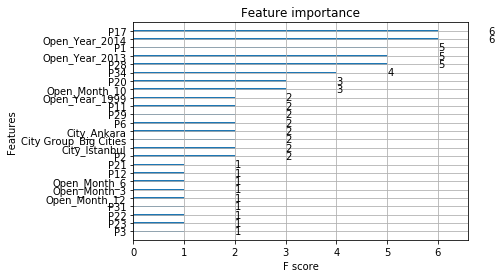

In [123]:
xgb.plot_importance(xgbFinal)

In [134]:
xgbFinal_train_preds = xgbFinal.predict(xgb.DMatrix(Train_X))
xgbFinal_test_preds = xgbFinal.predict(xgb.DMatrix(Test_X))

In [135]:
Train_RMSE = np.sqrt(mean_squared_error(Train_Y,xgbFinal_train_preds))
Test_RMSE = np.sqrt(mean_squared_error(Test_Y,xgbFinal_test_preds))
Train_RMSE = np.exp(Train_RMSE)
Test_RMSE = np.exp(Test_RMSE)
print(Train_RMSE)
print(Test_RMSE)

1.3791614437949278
1.7007115927670675


# Prediction for Kaggle Submission

In [136]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x))
xgbFinal_submission = np.exp(xgbFinal_submission)

In [137]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_testing_12th_trial.csv',header=True, index=False)

# Saving the final model

In [140]:
pickle.dump(xgbFinal, open("xgbFinal.pickle.dat", "wb"))

# Loading the final model

In [142]:
xgb_test = pickle.load(open("xgbFinal.pickle.dat", "rb"))

In [143]:
# Re-forecast the prediction to verify the model
xgb_test_p = xgb_test.predict(xgb.DMatrix(test_rf_x))
xgb_test_p = np.exp(xgb_test_p)

In [150]:
verify_model = (xgbFinal_submission == xgb_test_p)
verify_model.sum()

100000